# Sample from a univariate Gaussian distribution using a GAN
In this notebook, we'll train a GAN to sample from a 1-dimensional Gaussian distribution.

First, some imports:

In [1]:
import os
import torch
import torch.nn.parallel

import numpy as np
import torch.nn as nn
import matplotlib.pyplot as plt

os.chdir("/home/thomas/Backup/Algorithmen/GAN-pytorch")
# vegans imports:

from vegans.GAN import VanillaGAN
from vegans.utils.utils import plot_losses

ngpu = 0

Now we'll define some variables. `z_dim` is the size of the noise vector (input of the generator), while `mu` and `sigma` are the two parameters of the Gaussian distribution we'll try to learn.

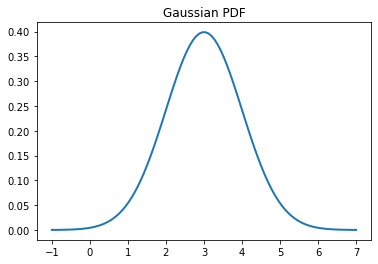

In [2]:
z_dim = 16

mu = 3.
sigma = 1.

def plot_gaussian(mu, sigma):
    x = np.linspace(mu - 4*sigma, mu + 4*sigma, 100)
    y = (1 / (np.sqrt(2 * np.pi * np.power(sigma, 2)))) * \
        (np.power(np.e, -(np.power((x - mu), 2) / (2 * np.power(sigma, 2)))))
    plt.plot(x, y, lw=2)
    plt.title('Gaussian PDF');
    
plot_gaussian(mu, sigma)

Let's create the training data and check if the empirical distribution of our samples matches our desired PDF:

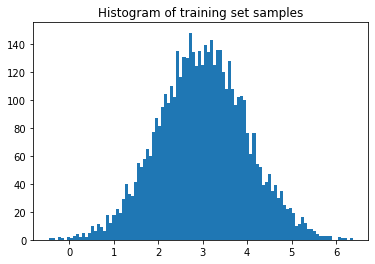

In [3]:
X_train = np.random.normal(loc=mu, scale=sigma, size=5000).reshape(-1, 1)
plt.hist(X_train, bins=100)
plt.title('Histogram of training set samples');

OK looks good!

## Definition of a Generator and a Discriminator:
Here we'll define simple networks with 2 fully connected layers and a ReLU nonlinearity:

In [4]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.hidden_part = nn.Sequential(
            nn.Linear(z_dim, 32),
            nn.LeakyReLU(0.1),
        )
        self.output = nn.Linear(32, 1)

    def forward(self, x):
        x = self.hidden_part(x)
        x = self.output(x)
        return x

class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.hidden_part = nn.Sequential(
            nn.Linear(1, 10),
            nn.LeakyReLU(0.1),
            nn.Linear(10, 1)
        )
        self.output = nn.Sigmoid()

    def forward(self, x):
        x = self.hidden_part(x)
        x = self.output(x)
        return x
    
discriminator = Discriminator()
generator = Generator()

Let's see the samples that our (untrained) generator outputs:

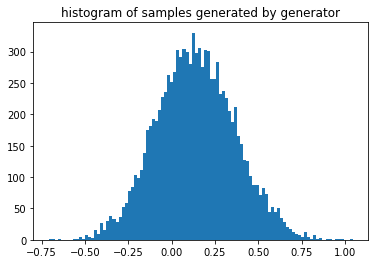

In [5]:
def plot_generator_distribution(generator, n=10000):
    """ Try the generator on a noise mini-batch
    """
    z = torch.from_numpy(np.random.randn(n, z_dim).astype(np.float32))
    samples = generator(z).cpu().detach().numpy().flatten()
    plt.hist(samples, bins=100)
    plt.title('histogram of samples generated by generator');
    
plot_generator_distribution(generator)

They are pretty far from our desired Gaussian; so let's train a GAN to try getting closer.
## Training a GAN
Here we'll use the [classic minimax GAN](https://papers.nips.cc/paper/5423-generative-adversarial-nets.pdf), training for 30 epochs, and saving 1024 samples along training.

In [9]:
gan = VanillaGAN(generator, discriminator, z_dim=z_dim, x_dim=1, ngpu=ngpu, fixed_noise_size=1024, folder=None, device="cpu")

Let's print a summary of the VanillaGAN to get a better overview of what's going on and check that everything is set up correctly.

In [10]:
gan.summary()

Generator
Input shape:  (16,)
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                   [-1, 32]             544
         LeakyReLU-2                   [-1, 32]               0
            Linear-3                    [-1, 1]              33
         Generator-4                    [-1, 1]               0
Total params: 577
Trainable params: 577
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.00
----------------------------------------------------------------



Adversariat
Input shape:  (1,)
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                   [-1, 10]              20
         LeakyReLU-2                   [-1, 10]  

In [11]:
gan.fit(X_train, print_every="0.1e", save_losses_every="0.1e", epochs=10, enable_tensorboard=False)

------------------------------------------------------------
EPOCH: 1
------------------------------------------------------------
Step: 15 / 1570 (Epoch: 1 / 10, Batch: 15 / 157)
------------------------------------------------------------
Generator: 0.4821508824825287
Adversariat: 0.5647530555725098
Adversariat_fake: 0.9645574688911438
Adversariat_real: 0.16494864225387573


Time left: ~0.068 minutes (Batches remaining: 1555).


Step: 30 / 1570 (Epoch: 1 / 10, Batch: 30 / 157)
------------------------------------------------------------
Generator: 0.48096466064453125
Adversariat: 0.563667893409729
Adversariat_fake: 0.967585563659668
Adversariat_real: 0.15975017845630646


Time left: ~0.06 minutes (Batches remaining: 1540).


Step: 45 / 1570 (Epoch: 1 / 10, Batch: 45 / 157)
------------------------------------------------------------
Generator: 0.46794408559799194
Adversariat: 0.5867626070976257
Adversariat_fake: 0.9911537170410156
Adversariat_real: 0.18237154185771942


Time left: ~0

/home/thomas/miniconda3/envs/pytorch38/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/thomas/miniconda3/envs/pytorch38/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Step: 105 / 1570 (Epoch: 1 / 10, Batch: 105 / 157)
------------------------------------------------------------
Generator: 0.47885531187057495
Adversariat: 0.6538479924201965
Adversariat_fake: 0.9735494256019592
Adversariat_real: 0.3341465890407562


Time left: ~0.048 minutes (Batches remaining: 1465).


Step: 120 / 1570 (Epoch: 1 / 10, Batch: 120 / 157)
------------------------------------------------------------
Generator: 0.5026881098747253
Adversariat: 0.6509742736816406
Adversariat_fake: 0.9346122741699219
Adversariat_real: 0.3673362135887146


Time left: ~0.048 minutes (Batches remaining: 1450).


Step: 135 / 1570 (Epoch: 1 / 10, Batch: 135 / 157)
------------------------------------------------------------
Generator: 0.5104324817657471
Adversariat: 0.6832418441772461
Adversariat_fake: 0.9242261648178101
Adversariat_real: 0.44225746393203735


Time left: ~0.048 minutes (Batches remaining: 1435).


Step: 150 / 1570 (Epoch: 1 / 10, Batch: 150 / 157)
--------------------------------

Step: 570 / 1570 (Epoch: 4 / 10, Batch: 99 / 157)
------------------------------------------------------------
Generator: 0.7220296859741211
Adversariat: 0.693152904510498
Adversariat_fake: 0.665084719657898
Adversariat_real: 0.7212210297584534


Time left: ~0.032 minutes (Batches remaining: 1000).


Step: 585 / 1570 (Epoch: 4 / 10, Batch: 114 / 157)
------------------------------------------------------------
Generator: 0.7187662720680237
Adversariat: 0.6936473250389099
Adversariat_fake: 0.6681752800941467
Adversariat_real: 0.7191193699836731


Time left: ~0.031 minutes (Batches remaining: 985).


Step: 600 / 1570 (Epoch: 4 / 10, Batch: 129 / 157)
------------------------------------------------------------
Generator: 0.7234705686569214
Adversariat: 0.6931256055831909
Adversariat_fake: 0.6637346744537354
Adversariat_real: 0.7225165367126465


Time left: ~0.031 minutes (Batches remaining: 970).


Step: 615 / 1570 (Epoch: 4 / 10, Batch: 144 / 157)
---------------------------------------

Step: 1005 / 1570 (Epoch: 7 / 10, Batch: 63 / 157)
------------------------------------------------------------
Generator: 0.694287121295929
Adversariat: 0.6932345628738403
Adversariat_fake: 0.6920091509819031
Adversariat_real: 0.6944600343704224


Time left: ~0.018 minutes (Batches remaining: 565).


Step: 1020 / 1570 (Epoch: 7 / 10, Batch: 78 / 157)
------------------------------------------------------------
Generator: 0.6927514672279358
Adversariat: 0.6929488182067871
Adversariat_fake: 0.6935431361198425
Adversariat_real: 0.6923545598983765


Time left: ~0.018 minutes (Batches remaining: 550).


Step: 1035 / 1570 (Epoch: 7 / 10, Batch: 93 / 157)
------------------------------------------------------------
Generator: 0.7064215540885925
Adversariat: 0.6933221817016602
Adversariat_fake: 0.6800660490989685
Adversariat_real: 0.7065783739089966


Time left: ~0.017 minutes (Batches remaining: 535).


Step: 1050 / 1570 (Epoch: 7 / 10, Batch: 108 / 157)
-------------------------------------

Step: 1425 / 1570 (Epoch: 10 / 10, Batch: 12 / 157)
------------------------------------------------------------
Generator: 0.6737332940101624
Adversariat: 0.6932506561279297
Adversariat_fake: 0.7130101323127747
Adversariat_real: 0.6734912395477295


Time left: ~0.005 minutes (Batches remaining: 145).


Step: 1440 / 1570 (Epoch: 10 / 10, Batch: 27 / 157)
------------------------------------------------------------
Generator: 0.6991957426071167
Adversariat: 0.6929585933685303
Adversariat_fake: 0.687140941619873
Adversariat_real: 0.6987763047218323


Time left: ~0.004 minutes (Batches remaining: 130).


Step: 1455 / 1570 (Epoch: 10 / 10, Batch: 42 / 157)
------------------------------------------------------------
Generator: 0.6923770904541016
Adversariat: 0.6931823492050171
Adversariat_fake: 0.6939204335212708
Adversariat_real: 0.6924443244934082


Time left: ~0.004 minutes (Batches remaining: 115).


Step: 1470 / 1570 (Epoch: 10 / 10, Batch: 57 / 157)
----------------------------------

## Inspecting Results
Let's have a look again at the distribution of samples coming from the generator:

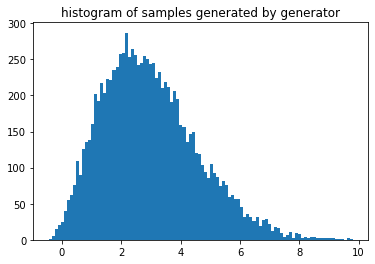

In [12]:
plot_generator_distribution(generator)

Not bad! It looks fairly close to our original Gaussian (note: it's probably possible to do better...).

We can also have a look at the evolution of the discriminator and generator losses:

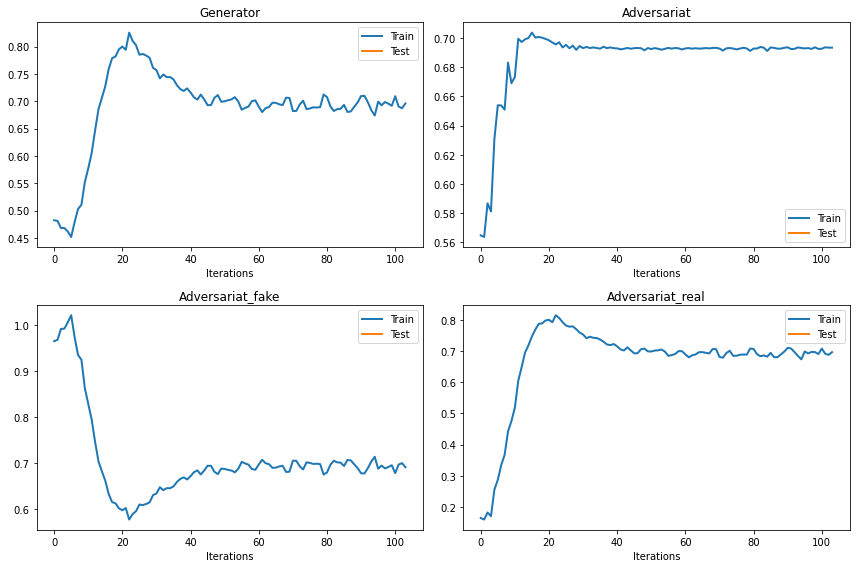

(<Figure size 864x576 with 4 Axes>,
 <AxesSubplot:title={'center':'Adversariat_real'}, xlabel='Iterations'>)

In [13]:
samples_l, losses = gan.get_training_results(by_epoch=False)
plot_losses(losses)